In [1234]:
import pandas as pd
import numpy as np
from collections import Counter
import os
import math
from scipy.stats import percentileofscore

# plotting bits from Lodve
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
from mplsoccer import pitch as mpl_pitch
from soccerplots.radar_chart import Radar

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [1189]:
# Lodve's plotting theme class

class Theme:
    
    homeCol = 'Red'
    homeECol = 'White'
    homeTxtCol = 'White'
    awayCol = 'Blue'
    awayECol = 'White'
    awaTxtCol = 'White'
    bgCol = None
    lnCol = None
    pitchCol = None
    pitchStripes = False
    txtCol = 'black'
    view = 'full'
    orientation = 'horizontal'
    inversePlayDir = False
    padLeft = 0
    padRight = 0
    padTop = 0
    padBottom = 0
    figSize = (12, 7.8)
    
    def __init__(self, match_meta=None):
        
        if match_meta is not None:
        
            self.homeCol = match_meta.homeTeamKitCol
            self.homeECol = match_meta.homeTeamKitNumCol
            self.homeTxtCol = match_meta.homeTeamKitNumCol
            self.awayCol = match_meta.awayTeamKitCol
            self.awayECol = match_meta.awayTeamKitNumCol
            self.awayTxtCol = match_meta.awayTeamKitNumCol
        
    
class LightTheme(Theme):
    
    bgCol = 'white'
    lnCol = 'grey'
    txtCol = 'black'
    pitchCol = 'white'


class DarkTheme(Theme):
    
    bgCol = '#D3D3D3'
    lnCol = 'lightgrey'
    txtCol = 'black'
    pitchCol = '#313332'
    

In [939]:
# Lodve's plotting radars (single player and two player comparison)

def plotRadars(player_ids, players, columns):
    
    ranges = []
    params = ["Passes",
              "Pass success",
              "Net pass progression",
              "High risk passes",
              "High risk pass success",
              "High xGA passes",
              "High xGA pass success",
              "xGA",
              "xP OP",
              "xP final 3rd OP"]
    end_note = "All units are per 90 minutes"
    
    for column in columns:
        
        min_range = np.percentile(players[column], 10)
        max_range = np.percentile(players[column], 99)
        ranges.append((min_range, max_range))
        

    for player_id in player_ids:
        
        player = players[players.playerId == player_id]
        name = player.name.values[0]
        team = player.team.values[0]
        position = player.position.values[0]
        minutes = player.minutes_played.values[0]
        matches = player.matches_played.values[0]
        
        title = dict(
            title_name = name,
            subtitle_name = team,
            title_name_2 = '2017/2018',
            subtitle_name_2 = position,
            title_fontsize = 18,
            subtitle_fontsize = 13,
            title_color = '#175379',
            subtitle_color = '#CE3B2C',
            title_color_2 = '#175379',
            subtitle_color_2 = '#CE3B2C')

        values = []
        
        for column in columns:
            
            value = player[column].values[0]
            values.append(value)

        radar = Radar()
        fig, ax = radar.plot_radar(ranges=ranges,
                                         params=params,
                                         values=values,
                                         radar_color=['#175379', '#CE2B2C'],
                                         dpi=300,
                                         title=title,
                                         endnote=end_note + "\n%d minutes/%d matches" % (minutes, matches))
        

def plotVSRadars(player_ids, players, columns, figax=None):
    ranges = []
    params = ["Passes",
              "Pass success",
              "Net pass progression",
              "High risk passes",
              "High risk pass success",
              "High xGA passes",
              "High xGA pass success",
              "xGA",
              "xP OP",
              "xP final 3rd OP"]
    end_note = "All units are per 90 minutes"
    
    for column in columns:
        
        min_range = np.percentile(players[column], 10)
        max_range = np.percentile(players[column], 99)
        ranges.append((min_range, max_range))
        

    player1 = players[players.playerId == player_ids[0]]
    name1 = player1.name.values[0]
    team1 = player1.team.values[0]
    player2 = players[players.playerId == player_ids[1]]
    name2 = player2.name.values[0]
    team2 = player2.team.values[0]
    matches1 = player1.matches_played.values[0]
    matches2 = player2.matches_played.values[0]

    
    title = dict(
        title_name = name1,
        subtitle_name = team1 + " - %d matches" % matches1,
        title_name_2 = name2,
        subtitle_name_2 = team2 + " - %d matches" % matches2,
        title_fontsize = 18,
        subtitle_fontsize = 13,
        title_color = '#175379',
        subtitle_color = '#175379',
        title_color_2 = '#CE3B2C',
        subtitle_color_2 = '#CE3B2C')
    
    values1 =[]
    values2 =[]
    values = [values1, values2]    
    
    for column in columns:
        
        value = player1[column].values[0]
        values1.append(value)
        value = player2[column].values[0]
        values2.append(value)

    radar = Radar(label_fontsize=14, range_fontsize=10)
    fig, ax = radar.plot_radar(ranges=ranges,
                               params=params,
                               values=values,
                               radar_color=['#175379', '#CE2B2C'],
                               dpi=150,
                               title=title,
                               endnote=end_note,
                               compare=True,
                               figax=figax)

### **Wyscout Event / Tags Discovery Function**

In [96]:
def show_event_breakdown(df_events, dic_tags):
    """
    Produces a full breakdown of the events, subevents, and the tags for the Wyscout dataset
    Use this to look at the various tags attributed to the event taxonomy
    """

    df_event_breakdown = df_events.groupby(['event_name','sub_event_name'])\
                        .agg({'id':'nunique','tags':lambda x: list(x)})\
                        .reset_index()\
                        .rename(columns={'id':'numSubEvents','tags':'tagList'})

    # creating a histogram of the tags per sub event
    df_event_breakdown['tagHist'] = df_event_breakdown.tagList.apply(lambda x: Counter([dic_tags[j] for i in x for j in i]))

    dic = {}

    for i, cols in df_event_breakdown.iterrows():
        eventName, subEventName, numEvents, tagList, tagHist = cols

        for key in tagHist:

            dic[f'{i}-{key}'] = [eventName, subEventName, numEvents, key, tagHist[key]]

    df_event_breakdown = pd.DataFrame.from_dict(dic, orient='index', columns=['event_name','sub_event_name','numSubEvents','tagKey','tagFrequency'])\
                                        .sort_values(['event_name','numSubEvents','tagFrequency'], ascending=[True, False, False])\
                                        .reset_index(drop=True)\

    return df_event_breakdown

### **ELO Functions**

In [441]:
def expected_win(r1, r2):
    """
    Expected probability of player 1 beating player 2
    if player 1 has rating 1 (r1) and player 2 has rating 2 (r2)
    """
    return 1.0 / (1 + math.pow(10, (r2-r1)/400))

def update_rating(R, k, P, d):
    """
    d = 1 = WIN
    d = 0 = LOSS
    """
    return R + k*(d-P)

In [442]:
def elo(Ra, Rb, k, d):
    """
    d = 1 when player A wins
    d = 0 when player B wins
    """
    
    Pa = expected_win(Ra, Rb)
    Pb = expected_win(Rb, Ra)
    
    # update if A wins
    if d == 1:
        Ra = update_rating(Ra, k, Pa, d)
        Rb = update_rating(Rb, k, Pb, d-1)
    
    # update if B wins
    elif d == 0:
        Ra = update_rating(Ra, k, Pa, d)
        Rb = update_rating(Rb, k, Pb, d+1)
    
    return Pa, Pb, Ra, Rb

In [443]:
def elo_attack_defence_sequence(things, initial_rating, k, results):
    """
    Initialises score dictionaries for attack and defence, and runs through sequence of pairwise results, returning final dictionaries with Elo rankings for both attack (dribblers) and defence (of dribblers)
    """

    dic_scores_attack = {i:initial_rating for i in things}
    dic_scores_defence = {i:initial_rating for i in things}

    for result in results:

        winner, loser, dribble_outcome = result
        
        # winner = attacker, loser = defender
        if dribble_outcome == 1:
            Ra, Rb = dic_scores_attack[winner], dic_scores_defence[loser]
            _, _, newRa, newRb = elo(Ra, Rb, k, 1)
            dic_scores_attack[winner], dic_scores_defence[loser] = newRa, newRb
        
        # winner = defender, loser = attacker
        elif dribble_outcome == 0:
            Ra, Rb = dic_scores_defence[winner], dic_scores_attack[loser]
            _, _, newRa, newRb = elo(Ra, Rb, k, 1)
            dic_scores_defence[winner], dic_scores_attack[loser] = newRa, newRb

    return dic_scores_attack, dic_scores_defence

### Mean Elo

In [681]:
def mElo(things, initial_rating, k, results, numEpochs):
    """
    Randomises the sequence of the pairwise comparisons, running the Elo sequence in a random
    sequence for a number of epochs
    
    Returns the mean Elo ratings over the randomised epoch sequences
    """
    
    lst_outcomes_attack = []
    lst_outcomes_defence = []
    
    for i in np.arange(numEpochs):
        np.random.shuffle(results)
        dic_scores_attack, dic_scores_defence = elo_attack_defence_sequence(things, initial_rating, k, results)
        lst_outcomes_attack.append(dic_scores_attack)
        lst_outcomes_defence.append(dic_scores_defence)
        
    df_attack = pd.DataFrame(lst_outcomes_attack).mean().sort_values(ascending=False).to_frame(name='eloAttack')
    df_attack['player'] = df_attack.index
    df_attack = df_attack.reset_index(drop=True)[['player','eloAttack']]

    df_defence = pd.DataFrame(lst_outcomes_defence).mean().sort_values(ascending=False).to_frame(name='eloDefence')
    df_defence['player'] = df_defence.index
    df_defence = df_defence.reset_index(drop=True)[['player','eloDefence']]
    
    df_elo = df_attack.merge(df_defence).sort_values('eloAttack', ascending=False)
    df_elo['eloDribbleRank'] = df_elo.index+1
    
    df_elo = df_elo.sort_values('eloDefence', ascending=False).reset_index(drop=True)
    df_elo['eloDribbleDefenceRank'] = df_elo.index+1
        
    return df_elo.sort_values('eloDribbleRank').reset_index(drop=True)
    

### **Wyscount Tags**

In [445]:
dic_tags = {
     101: 'Goal',
     102: 'Own goal',
     301: 'Assist',
     302: 'Key pass',
     1901: 'Counter attack',
     401: 'Left foot',
     402: 'Right foot',
     403: 'Head/body',
     1101: 'Direct',
     1102: 'Indirect',
     2001: 'Dangerous ball lost',
     2101: 'Blocked',
     801: 'High',
     802: 'Low',
     1401: 'Interception',
     1501: 'Clearance',
     201: 'Opportunity',
     1301: 'Feint',
     1302: 'Missed ball',
     501: 'Free space right',
     502: 'Free space left',
     503: 'Take on left',
     504: 'Take on right',
     1601: 'Sliding tackle',
     601: 'Anticipated',
     602: 'Anticipation',
     1701: 'Red card',
     1702: 'Yellow card',
     1703: 'Second yellow card',
     1201: 'Position: Goal low center',
     1202: 'Position: Goal low right',
     1203: 'Position: Goal center',
     1204: 'Position: Goal center left',
     1205: 'Position: Goal low left',
     1206: 'Position: Goal center right',
     1207: 'Position: Goal high center',
     1208: 'Position: Goal high left',
     1209: 'Position: Goal high right',
     1210: 'Position: Out low right',
     1211: 'Position: Out center left',
     1212: 'Position: Out low left',
     1213: 'Position: Out center right',
     1214: 'Position: Out high center',
     1215: 'Position: Out high left',
     1216: 'Position: Out high right',
     1217: 'Position: Post low right',
     1218: 'Position: Post center left',
     1219: 'Position: Post low left',
     1220: 'Position: Post center right',
     1221: 'Position: Post high center',
     1222: 'Position: Post high left',
     1223: 'Position: Post high right',
     901: 'Through',
     1001: 'Fairplay',
     701: 'Lost',
     702: 'Neutral',
     703: 'Won',
     1801: 'Accurate',
     1802: 'Not accurate'
}

### **Repos**

In [8]:
repo_processed_wyscout = 'Processed Wyscout'
repo_spadl = 'SPADL'

### **Loading CSVs**

### Formations, matches, players

In [364]:
df_formations = pd.read_csv('df_wyscout_formations.csv').rename(columns={'playerId':'player_id','matchId':'match_id','teamId':'team_id'})
df_matches = pd.read_csv('df_wyscout_matches.csv')
df_players = pd.read_csv('player_positions.csv').drop(columns=['Unnamed: 0'])
df_teams = pd.read_csv('df_teams.csv').rename(columns={'teamId':'team_id','teamName':'team_name','officialTeamName':'official_team_name','teamArea':'team_area'})

### Events

In [263]:
%%time

lst_leagues = os.listdir(repo_processed_wyscout)

lst_df = []

for league in lst_leagues:
    df_league = pd.read_csv(os.path.join(repo_processed_wyscout, league), converters={'tags': eval})
    df_league['source'] = league.replace('processed_wyscout_','').replace('_v1.csv','').title()
    lst_df.append(df_league)
    
df = pd.concat(lst_df, ignore_index=True)

# converting tags to a list of integers
df['tags'] = df.tags.apply(lambda x: list(x))

# adding interception flag
df['interception_flag'] = df.tags.apply(lambda x: 1 if 1401 in x else 0)

# removing the redundant index column Unnamed: 0
df = df.drop(columns=['Unnamed: 0'])

# getting rid of 709 events that don't have an end position
df = df.loc[pd.isna(df['end_x']) == False].copy()

df['event_sec'] = np.round(df.event_sec, 6)
df['start_x'] = np.round(df.start_x, 2)
df['start_y'] = np.round(df.start_y, 2)
df['end_x'] = np.round(df.end_x, 2)
df['end_y'] = np.round(df.end_y, 2)

print (f'Loaded {len(df)} rows from {len(lst_leagues)} leagues.')

Loaded 3070686 rows from 5 leagues.
CPU times: user 36.9 s, sys: 6 s, total: 42.9 s
Wall time: 43.6 s


In [304]:
%%time

df_spadl_actions = pd.read_csv('SPADL_Actions.csv').drop_duplicates()
df_spadl_xT = pd.read_csv('SPADL_xT.csv').drop_duplicates()

# urgh doing some more spadl transformations to help the join
df_spadl_actions['match_period'] = df_spadl_actions.period_id.apply(lambda x: '1H' if x == 1.0 else '2H')
df_spadl_xT['match_period'] = df_spadl_xT.period_id.apply(lambda x: '1H' if x == 1.0 else '2H')

df_spadl_actions = df_spadl_actions.rename(columns = {'game_id':'match_id', 'time_seconds':'event_sec'})
df_spadl_xT = df_spadl_xT.rename(columns = {'game_id':'match_id', 'time_seconds':'event_sec'})

# need this hacky interception flag to preseve uniqueness through the join from SPADL to 
df_spadl_actions['interception_flag'] = df_spadl_actions.type_name.apply(lambda x: 1 if x == 'interception' else 0)
df_spadl_xT['interception_flag'] = df_spadl_xT.type_name.apply(lambda x: 1 if x == 'interception' else 0)

# converting the event secs to 6dp and positions to 2dp
df_spadl_actions['event_sec'] = np.round(df_spadl_actions.event_sec, 6)
df_spadl_xT['event_sec'] = np.round(df_spadl_xT.event_sec, 6)

df_spadl_actions['start_x'] = np.round(df_spadl_actions.start_x, 2)
df_spadl_actions['start_y'] = np.round(df_spadl_actions.start_y, 2)
df_spadl_actions['end_x'] = np.round(df_spadl_actions.end_x, 2)
df_spadl_actions['end_y'] = np.round(df_spadl_actions.end_y, 2)

df_spadl_xT['start_x'] = np.round(df_spadl_xT.start_x, 2)
df_spadl_xT['start_y'] = np.round(df_spadl_xT.start_y, 2)
df_spadl_xT['end_x'] = np.round(df_spadl_xT.end_x, 2)
df_spadl_xT['end_y'] = np.round(df_spadl_xT.end_y, 2)

print (f'Loaded SPADL data.')

Loaded SPADL data.
CPU times: user 8.62 s, sys: 1.78 s, total: 10.4 s
Wall time: 10.6 s


### **Merging into a single dataframe**

In [305]:
%%time

# merging xT with spadl
df_spadl_actions_xT = df_spadl_actions.merge(df_spadl_xT, how='left', on=['match_id', 'period_id', 'event_sec', 'team_id', 'player_id', 'start_x',\
                                                                           'start_y', 'end_x', 'end_y', 'bodypart_id', 'type_id', 'result_id',\
                                                                           'type_name', 'result_name', 'bodypart_name', 'match_period',\
                                                                           'interception_flag'])

# merging spadl with wyscout
df_combined = df.merge(df_spadl_actions_xT, how='left', on=['match_id','match_period','event_sec','team_id','player_id','start_x','start_y','interception_flag'], suffixes=('_wyscout','_SPADL'))


CPU times: user 46.5 s, sys: 6.52 s, total: 53 s
Wall time: 53.3 s


#### Investigating what's in Wyscout but not SPADL

In [1411]:
df.sub_event_name.value_counts()

Simple pass                1207448
Ground attacking duel       265456
Ground defending duel       264552
Touch                       165296
Air duel                    158186
Ground loose ball duel      143861
Ball out of the field       129179
High pass                   123214
Head pass                    91194
Throw in                     80305
Cross                        58634
Clearance                    53165
Foul                         44293
Free Kick                    43544
Launch                       43303
Shot                         40461
Goal kick                    29725
Smart pass                   28428
Acceleration                 24376
Corner                       18181
Hand pass                    13135
Reflexes                     10192
Free kick cross               8134
Save attempt                  6375
Goalkeeper leaving line       5779
Free kick shot                2038
Hand foul                     1941
Whistle                        917
Penalty             

In [446]:
df_combined.loc[pd.isna(df_combined['type_name']) == True].sub_event_name.value_counts()

Ground defending duel      243907
Ground attacking duel      208229
Air duel                   152272
Ground loose ball duel     130978
Ball out of the field      129179
Touch                       91775
Clearance                   30200
Goal kick                   29725
Reflexes                    10190
Save attempt                 6367
Goalkeeper leaving line      5779
Acceleration                 1161
Whistle                       917
Shot                          315
Head pass                       1
Name: sub_event_name, dtype: int64

In [1412]:
df_spadl_actions.type_name.value_counts()

pass                1549407
dribble              184013
interception         125995
throw_in              80305
cross                 58634
clearance             53165
take_on               51631
foul                  47955
freekick_short        43544
shot                  40461
goalkick              29725
tackle                15949
corner_crossed        14193
keeper_save           11796
freekick_crossed       8134
corner_short           3988
shot_freekick          2038
shot_penalty            541
Name: type_name, dtype: int64

#### Investigating shots

In [323]:
df_combined.loc[df_combined['sub_event_name'] == 'Shot', ['match_id','team_id','player_id','sub_event_name','start_x','start_y','end_x_wyscout','end_y_wyscout','end_x_SPADL','end_y_SPADL','type_name','result_name']]

,match_id,team_id,player_id,sub_event_name,start_x,start_y,end_x_wyscout,end_y_wyscout,end_x_SPADL,end_y_SPADL,type_name,result_name
20,2565548,695,225089,Shot,97.65,44.88,0.0,68.0,105.00,34.00,shot,fail
22,2565548,695,255738,Shot,84.00,27.88,0.0,68.0,84.00,27.88,shot,fail
107,2565548,682,37831,Shot,92.40,29.24,105.0,0.0,92.40,29.24,shot,fail
111,2565548,682,15214,Shot,91.35,23.12,105.0,0.0,105.00,27.20,shot,fail
228,2565548,695,225089,Shot,78.75,40.80,0.0,68.0,105.00,34.00,shot,fail
...,...,...,...,...,...,...,...,...,...,...,...,...
3070317,2517044,2451,15191,Shot,90.30,25.16,0.0,68.0,105.00,30.60,shot,fail
3070483,2517044,2451,14917,Shot,95.55,39.44,0.0,68.0,105.00,37.40,shot,success
3070523,2517044,2451,134708,Shot,73.50,42.16,0.0,68.0,105.00,34.00,shot,fail
3070797,2517044,2451,284469,Shot,95.55,47.60,0.0,68.0,105.00,30.60,shot,success


---

&nbsp;

&nbsp;

# **Analysis**

In [99]:
df_spadl_actions.type_name.value_counts()



pass                1549407
dribble              184013
interception         125995
throw_in              80305
cross                 58634
clearance             53165
take_on               51631
foul                  47955
freekick_short        43544
shot                  40461
goalkick              29725
tackle                15949
corner_crossed        14193
keeper_save           11796
freekick_crossed       8134
corner_short           3988
shot_freekick          2038
shot_penalty            541
Name: type_name, dtype: int64

In [451]:
df_breakdown = show_event_breakdown(df, dic_tags)


## xT Defensive Analysis

In [322]:
df_spadl_xT.head()


,match_id,period_id,event_sec,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,type_name,result_name,bodypart_name,xT_value,match_period,interception_flag
0,2500089,1.0,2.763597,1659,9637,52.50,34.00,42.00,37.40,0,0,1,pass,success,foot,-0.001963,1H,0
1,2500089,1.0,4.761353,1659,8351,42.00,37.40,40.95,57.80,0,0,1,pass,success,foot,-0.001333,1H,0
2,2500089,1.0,5.533097,1659,9285,40.95,57.80,32.55,47.60,0,0,1,pass,success,foot,-0.000447,1H,0
3,2500089,1.0,7.707561,1659,239411,32.55,47.60,69.30,48.96,0,0,1,pass,success,foot,0.008080,1H,0
4,2500089,1.0,11.614943,1659,9637,69.30,48.96,74.55,55.76,0,0,1,pass,success,foot,0.001749,1H,0


* Need a nice way of gridding this
* Need a nice way of plotting this

## Winger Analysis

In [1404]:
def plot_xTMap(xT, theme, team_id, bins=(16,12), actions=['cross','pass','dribble'], players=None, vmax_override=None, saveFlag=0):
    """
    player_id 14812 = Perisic
    player_id 20556 = Cantreva
    """
    
    if players == None:
        xT = xT.loc[(xT['team_id'] == team_id) & (xT['type_name'].isin(actions))]
    else:
        xT = xT.loc[(xT['team_id'] == team_id) & (xT['type_name'].isin(actions)) &  (xT['player_id'].isin(players))]
    
    # merging xT with teams dataframe
    xT = xT.merge(df_teams)
        
    team_xT = xT[xT.team_id == team_id]
    oppo_xT = xT[xT.team_id != team_id]

    team_name = team_xT.team_name.unique()[0]

    team_pitch = mpl_pitch.Pitch(pitch_type='uefa', figsize=(16,9), pitch_color=theme.bgCol, line_zorder=2, line_color=theme.bgCol)
    team_fig, team_ax = team_pitch.draw()
    team_fig.patch.set_facecolor(theme.bgCol)
    team_bin_statistic = team_pitch.bin_statistic(team_xT.start_x, team_xT.start_y, team_xT.xT_value, statistic='sum', bins=bins)
    vmax = team_bin_statistic['statistic'].max()
    vmin = 0

    if vmax_override != None:
        vmax = vmax_override
    
    team_pcm = team_pitch.heatmap(team_bin_statistic, ax=team_ax, cmap='Reds', edgecolors='white', vmin=vmin, vmax=vmax)
    team_scatter = team_pitch.scatter(xT.start_x, xT.start_y, c='white', s=2, ax=team_ax)
    #team_pcm.axes.invert_yaxis()
    #team_cbar = team_fig.colorbar(team_pcm, ax=team_ax)
    #title = team_fig.suptitle(f'Origions of threat by location for {team_name}, Serie A 2017/18', x=0.4, y=0.98, fontsize=23, color='black')
    
    if saveFlag == 1:
        team_fig.savefig(f'{team_name}.png', dpi=300, transparent=True)

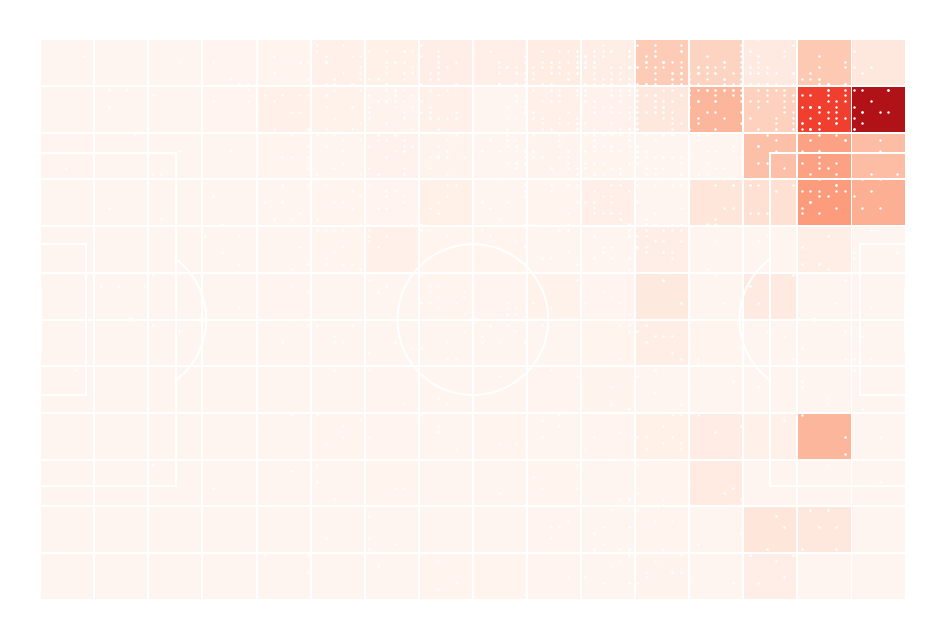

In [1405]:
# perisic
plot_xTMap(df_spadl_xT, theme, team_id=3161, bins=(16,12), actions=['cross','pass','dribble'], players=[14812], vmax_override=1.5, saveFlag=1)

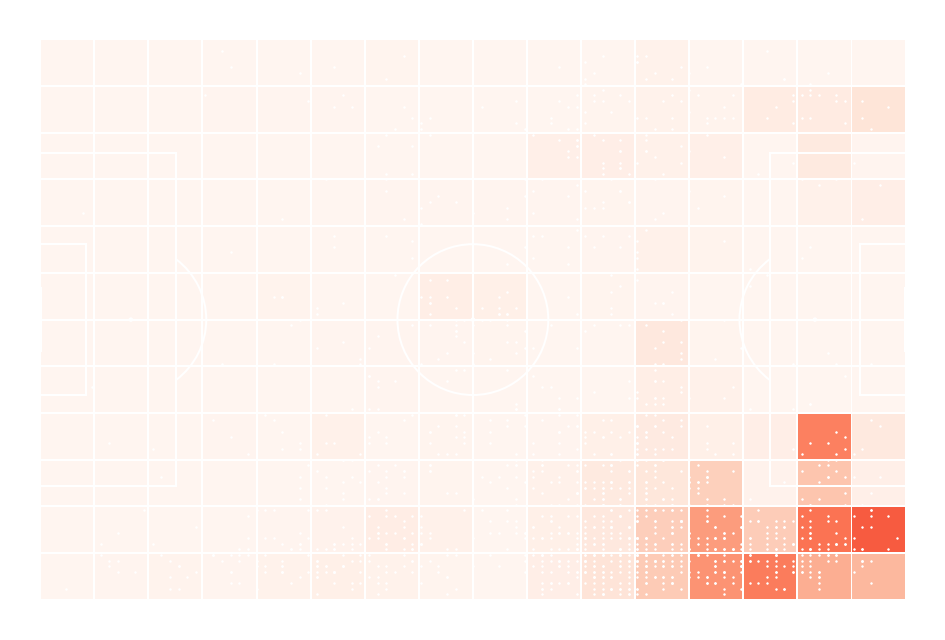

In [1406]:
# candreva
plot_xTMap(df_spadl_xT, theme, team_id=3161, bins=(16,12), actions=['cross','pass','dribble'], players=[20556], vmax_override=1.5, saveFlag=1)

## **Moses & Sanchez Scouting**

In [1387]:
player_map.loc[player_map['player_name'].str.contains('Moses')]

,player_id,team_id,player_name,player_role,player_position,team_name,official_team_name,teamType,team_area
483,8625,1610,Victor Moses,Midfielder,Right MF,Chelsea,Chelsea FC,club,England
2409,379207,1633,Moses Makasi,Midfielder,NaN,West Ham United,West Ham United FC,club,England
3308,8625,16823,Victor Moses,Midfielder,Right MF,Nigeria,Nigeria,national,Nigeria


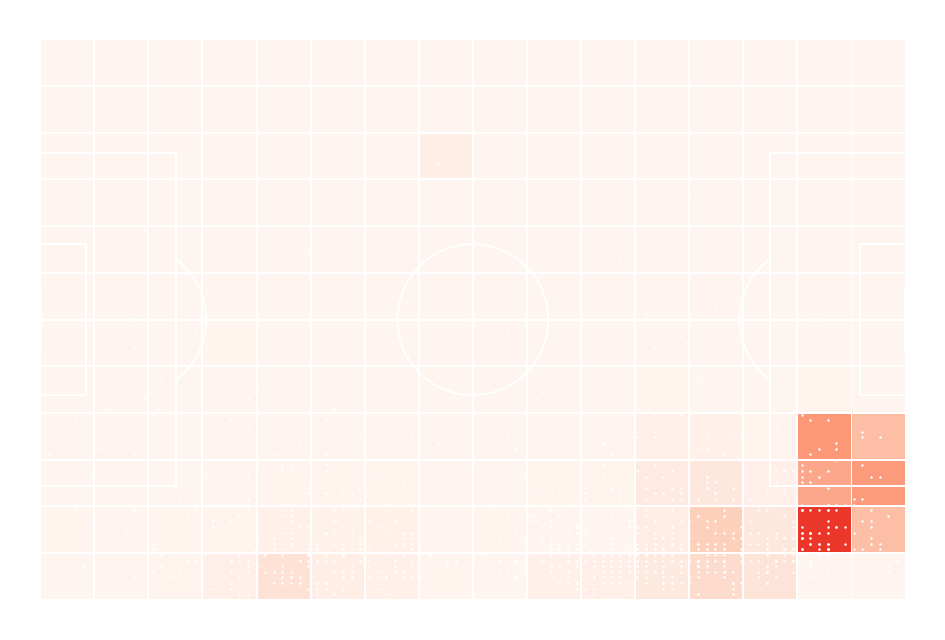

In [1407]:
# Moses
plot_xTMap(df_spadl_xT, theme, team_id=1610, bins=(16,12), actions=['cross','pass','dribble'], players=[8625], vmax_override=1.5, saveFlag=1)

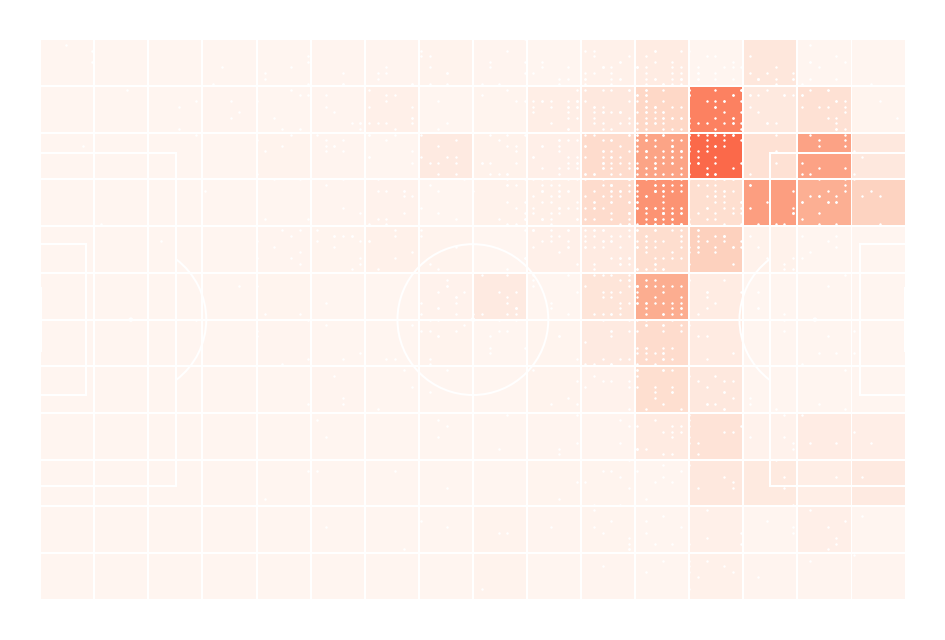

In [1408]:
# Sanchez
#plot_xTMap(df_spadl_xT, theme, team_id=1609, bins=(16,12), actions=['cross','pass','dribble'], players=[3361], vmax_override=1.5)

actions=['cross','pass','dribble']
bins=(16,12)
vmax_override=1.5
player_id = 3361

xT = df_spadl_xT.loc[(df_spadl_xT['player_id'] == player_id) & (df_spadl_xT['type_name'].isin(actions))]
    
# merging xT with teams dataframe
xT = xT.merge(df_teams)

team_pitch = mpl_pitch.Pitch(pitch_type='uefa', figsize=(16,9), pitch_color=theme.bgCol, line_zorder=2, line_color=theme.bgCol)
team_fig, team_ax = team_pitch.draw()
team_fig.patch.set_facecolor(theme.bgCol)
team_bin_statistic = team_pitch.bin_statistic(xT.start_x, xT.start_y, xT.xT_value, statistic='sum', bins=bins)
vmax = team_bin_statistic['statistic'].max()
vmin = 0

if vmax_override != None:
    vmax = vmax_override

team_pcm = team_pitch.heatmap(team_bin_statistic, ax=team_ax, cmap='Reds', edgecolors='white', vmin=vmin, vmax=vmax)
team_scatter = team_pitch.scatter(xT.start_x, xT.start_y, c='white', s=2, ax=team_ax)
#team_pcm.axes.invert_yaxis()
#team_cbar = team_fig.colorbar(team_pcm, ax=team_ax)
#title = team_fig.suptitle(f'Origions of threat by location for {team_name}, Serie A 2017/18', x=0.4, y=0.98, fontsize=23, color='black')

team_fig.savefig(f'Alexis Sanchez.png', dpi=300, transparent=True)

---

&nbsp;

&nbsp;

&nbsp;

# **Delta Strategy Analysis**

In [1181]:
df_teams.loc[df_teams['team_area'] == 'Germany']

,team_id,team_name,official_team_name,teamType,team_area
7,2454,Borussia M'gladbach,Borussia VfL Mönchengladbach,club,Germany
28,2443,Werder Bremen,SV Werder Bremen,club,Germany
29,2446,Bayer Leverkusen,TSV Bayer 04 Leverkusen,club,Germany
30,2447,Borussia Dortmund,BV Borussia 09 Dortmund,club,Germany
31,2444,Bayern München,FC Bayern München,club,Germany
32,2445,Stuttgart,VfB Stuttgart 1893,club,Germany
33,2449,Schalke 04,FC Schalke 04,club,Germany
41,2455,Hannover 96,Hannover 96,club,Germany
43,2457,Hertha BSC,Hertha BSC,club,Germany
44,2451,Wolfsburg,VfL Wolfsburg,club,Germany


CPU times: user 8.8 s, sys: 445 ms, total: 9.24 s
Wall time: 3.79 s


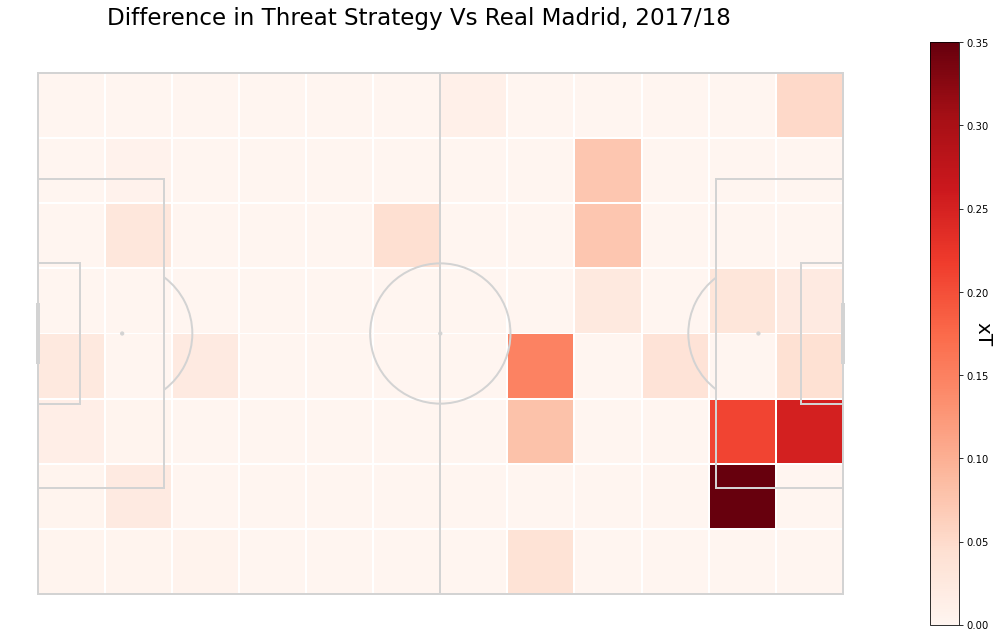

In [1228]:
%%time

bins = (12,8)

theme = LightTheme()

# identifying teams
## inter = 3161
## juve = 3159
## ac = 3157
## man u = 1611
## city = 1609
## real = 675
## barca = 676
## bayern = 2444
## bvb = 2447

# specify league here
league = 'Spain'
# specify team of interest here
inter_team_id = 675
team_name = 'Real Madrid'

other_team_ids = list(set(df_teams.loc[(df_teams['team_area'] == league) & (df_teams['teamType'] != 'national')].team_id.values) - set([inter_team_id]))

# dataframe: matchId | homeTeamId | awayTeamId
df_italy_matches = df_matches.loc[df_matches['source'] == league, ['matchId','homeTeamId','awayTeamId']].reset_index(drop=True)

# dict: {matchId: [home, away]}
dic_matches = {i:[j,k] for i,j,k in zip(df_italy_matches.matchId,df_italy_matches.homeTeamId,df_italy_matches.awayTeamId)}

# looping through the matches
vs_inter_delta = np.zeros((bins[1], bins[0]))

# greating a team_pitch object as we'll be using a method buried within to capture the counts in a 2D numpy array
team_pitch = mpl_pitch.Pitch(pitch_type='uefa', figsize=(16,9), pitch_color=theme.bgCol, line_zorder=20, line_color='#D3D3D3')#line_color=theme.bgCol)
team_fig, team_ax = team_pitch.draw()
team_fig.patch.set_facecolor(theme.bgCol)

for opp_team_id in other_team_ids:
    
    # each opposition team will have two grids to store the xT counts
    vs_inter = np.zeros((bins[1], bins[0]))
    vs_other = np.zeros((bins[1], bins[0]))
    
    # getting lists of match ids for the other teams, separating out the matches vs inter and the matches vs other teams
    ## getting the frequencies, too, as we'll use those to average things out later
    opp_team_matches_vs_inter = [i for i in dic_matches.keys() if opp_team_id in dic_matches[i] and inter_team_id in dic_matches[i]]
    freq_vs_inter = len(opp_team_matches_vs_inter)
    
    opp_team_matches_vs_other = [i for i in dic_matches.keys() if opp_team_id in dic_matches[i] and inter_team_id not in dic_matches[i]]
    freq_vs_other = len(opp_team_matches_vs_other)
    
    ## starting with 
    for match_id in opp_team_matches_vs_inter:
        df_xT_match =  df_spadl_xT.loc[(df_spadl_xT['match_id'] == match_id) & (df_spadl_xT['team_id'] == opp_team_id)].copy()
        vs_inter += team_pitch.bin_statistic(df_xT_match.start_x, df_xT_match.start_y, df_xT_match.xT_value, statistic='sum', bins=bins)['statistic']
    
    for match_id in opp_team_matches_vs_other:
        df_xT_match =  df_spadl_xT.loc[(df_spadl_xT['match_id'] == match_id) & (df_spadl_xT['team_id'] == opp_team_id)].copy()
        vs_other += team_pitch.bin_statistic(df_xT_match.start_x, df_xT_match.start_y, df_xT_match.xT_value, statistic='sum', bins=bins)['statistic']
        
    # calculating averages
    mean_vs_inter = vs_inter / freq_vs_inter
    mean_vs_other = vs_other / freq_vs_other
    
    # adding to delta
    vs_inter_delta += (mean_vs_inter - mean_vs_other)
    
# providing overlay - the statistics here don't matter - we'll override these soon
team_bin_statistic = team_pitch.bin_statistic(df_xT_match.end_x, df_xT_match.end_y, df_xT_match.xT_value, statistic='sum', bins=bins)
        
# overriding single match with the aggregated delta
team_bin_statistic['statistic'] = vs_inter_delta

# setting the colour scale
vmax = team_bin_statistic['statistic'].max()
vmin = 0

# plotting the heatmap
team_pcm = team_pitch.heatmap(team_bin_statistic, ax=team_ax, cmap='Reds', edgecolors='white', vmin=vmin, vmax=0.35)
team_cbar = team_fig.colorbar(team_pcm, ax=team_ax)
team_cbar.set_label('xT', rotation=270, fontsize=20)
title = team_fig.suptitle(f'Difference in Threat Strategy Vs {team_name}, 2017/18', x=0.4, y=0.98, fontsize=23, color='black')

team_fig.savefig('Difference_In_Threat_Vs_Real.png', transparent=True, dpi=300)


---

&nbsp;

&nbsp;

## **Kicking off the xT metrics**

In [1471]:
min_minutes = 0

df_spadl_xT_players = df_spadl_actions_xT.merge(df_players).merge(df_teams, on=['team_id'], how='inner')\
                        [['match_id', 'period_id', 'event_sec', 'team_id','official_team_name','team_area', 'player_id','player_name', 'player_role', 'player_position',
                          'start_x','start_y', 'end_x', 'end_y', 'bodypart_id', 'type_id', 'result_id','type_name', 'result_name', 'bodypart_name', 'xT_value', 'match_period']]

df_spadl_xT_players.head()

,match_id,period_id,event_sec,team_id,official_team_name,team_area,player_id,player_name,player_role,player_position,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,type_name,result_name,bodypart_name,xT_value,match_period
0,2500089,1.0,2.763597,1659,AFC Bournemouth,England,9637,Joshua King,Forward,Central FW,52.50,34.00,42.00,37.40,0,0,1,pass,success,foot,-0.001963,1H
1,2500089,1.0,11.614943,1659,AFC Bournemouth,England,9637,Joshua King,Forward,Central FW,69.30,48.96,74.55,55.76,0,0,1,pass,success,foot,0.001749,1H
2,2500089,1.0,107.743255,1659,AFC Bournemouth,England,9637,Joshua King,Forward,Central FW,46.20,5.44,46.20,5.44,0,8,1,foul,success,foot,NaN,1H
3,2500089,1.0,362.274445,1659,AFC Bournemouth,England,9637,Joshua King,Forward,Central FW,47.25,36.04,79.80,12.92,0,0,1,pass,success,foot,0.011088,1H
4,2500089,1.0,407.082418,1659,AFC Bournemouth,England,9637,Joshua King,Forward,Central FW,58.80,25.16,59.85,30.60,0,0,1,pass,success,foot,0.000498,1H


## Crossing

In [1472]:
                                                              #& (df_spadl_xT_players['team_area'] == 'England')\
                                                              #& (df_spadl_xT_players['player_position'].isin(['Right MF','Left MF','Left FW','Right FW']))]\

df_spadl_xT_winger_crossing_threat = df_spadl_xT_players.loc[(df_spadl_xT_players['type_name'] == 'cross')]\
                                        .groupby(['team_id','official_team_name','player_id','player_name','player_position','match_id'])\
                                        .agg({'xT_value':np.sum,'result_id':np.sum,'result_name':'count'})\
                                        .reset_index()\
                                        .rename(columns={'result_id':'numSuccessful','result_name':'numAttempts'})\
                                        .merge(df_formations, on=['team_id','player_id','match_id'], how='inner')\
                                        .groupby(['team_id','official_team_name','player_id','player_name','player_position'])\
                                        .agg({'minutesPlayed':np.sum,'xT_value':np.sum,'numSuccessful':np.sum,'numAttempts':np.sum})\
                                        .sort_values('xT_value', ascending=False)\
                                        .reset_index()
                                
df_spadl_xT_winger_crossing_threat['xT_crossing_per_90'] = 90*(df_spadl_xT_winger_crossing_threat['xT_value']) / df_spadl_xT_winger_crossing_threat['minutesPlayed']
df_spadl_xT_winger_crossing_threat['xT_crossing_per_cross'] = df_spadl_xT_winger_crossing_threat['xT_value'] / df_spadl_xT_winger_crossing_threat['numSuccessful']
df_spadl_xT_winger_crossing_threat['xT_crossing_per_attempt'] = df_spadl_xT_winger_crossing_threat['xT_value'] / df_spadl_xT_winger_crossing_threat['numAttempts']
df_spadl_xT_winger_crossing_threat['cross_success_rate'] = df_spadl_xT_winger_crossing_threat['numSuccessful'] / df_spadl_xT_winger_crossing_threat['numAttempts']

# min 900 minutes
df_spadl_xT_winger_crossing_threat = df_spadl_xT_winger_crossing_threat.loc[df_spadl_xT_winger_crossing_threat['minutesPlayed'] >= min_minutes].copy()

df_spadl_xT_winger_crossing_threat = df_spadl_xT_winger_crossing_threat.sort_values('xT_crossing_per_90', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_crossing_threat['xT_crossing_per_90_rank'] = df_spadl_xT_winger_crossing_threat.index + 1

df_spadl_xT_winger_crossing_threat = df_spadl_xT_winger_crossing_threat.sort_values('xT_crossing_per_attempt', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_crossing_threat['xT_crossing_per_attempt_rank'] = df_spadl_xT_winger_crossing_threat.index + 1

df_spadl_xT_winger_crossing_threat = df_spadl_xT_winger_crossing_threat.sort_values('xT_crossing_per_cross', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_crossing_threat['xT_crossing_per_cross_rank'] = df_spadl_xT_winger_crossing_threat.index + 1

df_spadl_xT_winger_crossing_threat = df_spadl_xT_winger_crossing_threat.sort_values('cross_success_rate', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_crossing_threat['cross_success_rate_rank'] = df_spadl_xT_winger_crossing_threat.index + 1

df_spadl_xT_winger_crossing_threat = df_spadl_xT_winger_crossing_threat.sort_values('xT_value', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_crossing_threat['xT_cross_rank_overall'] = df_spadl_xT_winger_crossing_threat.index + 1

df_spadl_xT_winger_crossing_threat.sort_values('xT_cross_rank_overall')

,team_id,official_team_name,player_id,player_name,player_position,minutesPlayed,xT_value,numSuccessful,numAttempts,xT_crossing_per_90,xT_crossing_per_cross,xT_crossing_per_attempt,cross_success_rate,xT_crossing_per_90_rank,xT_crossing_per_attempt_rank,xT_crossing_per_cross_rank,cross_success_rate_rank,xT_cross_rank_overall
0,687,Real Sociedad de Fútbol,278289,Álvaro Odriozola Arzallus,Right DF,2911.0,6.597780,79,190,0.203985,0.083516,0.034725,0.415789,85,454,743,515,1
1,2481,FC Augsburg,221411,Philipp Max,Left DF,2960.0,6.326610,82,177,0.192363,0.077154,0.035744,0.463277,100,424,949,390,2
2,675,Real Madrid Club de Fútbol,3310,Marcelo Vieira da Silva Júnior,Left DF,2264.0,5.985057,65,188,0.237922,0.092078,0.031835,0.345745,55,570,487,823,3
3,3157,AC Milan,11063,Jesús Joaquín Fernández Sáez de la Torre,Right FW,2839.0,5.966330,59,172,0.189140,0.101124,0.034688,0.343023,104,456,313,835,4
4,3777,FC Metz,26512,Mathieu Dossevi,Right MF,2514.0,5.956837,60,164,0.213252,0.099281,0.036322,0.365854,73,405,354,724,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,3187,SSC Napoli,3300,Raúl Albiol Tortajada,Right CB,360.0,-0.035536,2,4,-0.008884,-0.017768,-0.008884,0.500000,2162,2164,1863,342,2163
2163,684,Real Betis Balompié,3335,Marc Bartra Aregall,Right CB,270.0,-0.035794,1,3,-0.011931,-0.035794,-0.011931,0.333333,2164,2166,1869,916,2164
2164,2444,FC Bayern München,134383,Niklas Süle,Right CB,371.0,-0.038573,1,5,-0.009357,-0.038573,-0.007715,0.200000,2163,2163,1870,1688,2165
2165,2444,FC Bayern München,3345,Thiago Alcântara do Nascimento,Central MF,271.0,-0.040969,2,7,-0.013606,-0.020484,-0.005853,0.285714,2165,2162,1864,1243,2166


## Dribbling

In [1473]:
                                                              #& (df_spadl_xT_players['team_area'] == 'Italy')\
                                                              #& (df_spadl_xT_players['player_position'].isin(['Right MF','Left MF','Left FW','Right FW']))]\

df_spadl_xT_winger_dribbling_threat = df_spadl_xT_players.loc[(df_spadl_xT_players['type_name'] == 'dribble')]\
                                        .groupby(['team_id','official_team_name','player_id','player_name','player_position','match_id'])\
                                        .agg({'xT_value':np.sum,'result_id':np.sum,'result_name':'count'})\
                                        .reset_index()\
                                        .rename(columns={'result_id':'numSuccessful','result_name':'numAttempts'})\
                                        .merge(df_formations, on=['team_id','player_id','match_id'], how='inner')\
                                        .groupby(['team_id','official_team_name','player_id','player_name','player_position'])\
                                        .agg({'minutesPlayed':np.sum,'xT_value':np.sum,'numSuccessful':np.sum,'numAttempts':np.sum})\
                                        .sort_values('xT_value', ascending=False)\
                                        .reset_index()
                                
df_spadl_xT_winger_dribbling_threat['xT_dribbling_per_90'] = 90*(df_spadl_xT_winger_dribbling_threat['xT_value']) / df_spadl_xT_winger_dribbling_threat['minutesPlayed']
df_spadl_xT_winger_dribbling_threat['xT_dribbling_per_dribble'] = df_spadl_xT_winger_dribbling_threat['xT_value'] / df_spadl_xT_winger_dribbling_threat['numSuccessful']
df_spadl_xT_winger_dribbling_threat['xT_dribbling_per_attempt'] = df_spadl_xT_winger_dribbling_threat['xT_value'] / df_spadl_xT_winger_dribbling_threat['numAttempts']
df_spadl_xT_winger_dribbling_threat['dribble_success_rate'] = df_spadl_xT_winger_dribbling_threat['numSuccessful'] / df_spadl_xT_winger_dribbling_threat['numAttempts']

# min 900 minutes
df_spadl_xT_winger_dribbling_threat = df_spadl_xT_winger_dribbling_threat.loc[df_spadl_xT_winger_dribbling_threat['minutesPlayed'] >= min_minutes].copy()

df_spadl_xT_winger_dribbling_threat = df_spadl_xT_winger_dribbling_threat.sort_values('xT_dribbling_per_90', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_dribbling_threat['xT_dribbling_per_90_rank'] = df_spadl_xT_winger_dribbling_threat.index + 1

df_spadl_xT_winger_dribbling_threat = df_spadl_xT_winger_dribbling_threat.sort_values('xT_dribbling_per_attempt', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_dribbling_threat['xT_dribbling_per_attempt_rank'] = df_spadl_xT_winger_dribbling_threat.index + 1

df_spadl_xT_winger_dribbling_threat = df_spadl_xT_winger_dribbling_threat.sort_values('xT_dribbling_per_dribble', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_dribbling_threat['xT_dribbling_per_dribble_rank'] = df_spadl_xT_winger_dribbling_threat.index + 1

df_spadl_xT_winger_dribbling_threat = df_spadl_xT_winger_dribbling_threat.sort_values('xT_value', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_dribbling_threat['xT_dribbling_rank_overall'] = df_spadl_xT_winger_dribbling_threat.index + 1

df_spadl_xT_winger_dribbling_threat

,team_id,official_team_name,player_id,player_name,player_position,minutesPlayed,xT_value,numSuccessful,numAttempts,xT_dribbling_per_90,xT_dribbling_per_dribble,xT_dribbling_per_attempt,dribble_success_rate,xT_dribbling_per_90_rank,xT_dribbling_per_attempt_rank,xT_dribbling_per_dribble_rank,xT_dribbling_rank_overall
0,2975,Rasen Ballsport Leipzig,173214,Timo Werner,Central FW,2500.0,1.949712,171,175,0.070190,0.011402,0.011141,0.977143,51,54,53,1
1,3799,Angers SCO,26638,Karl Toko Ekambi,Central FW,3009.0,1.786221,240,242,0.053426,0.007443,0.007381,0.991736,83,123,125,2
2,3204,Società Polisportiva Ars et Labor 2013,226200,Manuel Lazzari,Right MF,3119.0,1.757253,319,327,0.050706,0.005509,0.005374,0.975535,92,229,227,3
3,695,Levante UD,225089,José Luis Morales Nogales,Central MF,3080.0,1.696744,260,269,0.049580,0.006526,0.006308,0.966543,96,170,165,4
4,692,Real Club Celta de Vigo,3840,Iago Aspas Juncal,Central FW,2927.0,1.660637,233,235,0.051062,0.007127,0.007067,0.991489,90,133,135,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,2481,FC Augsburg,15777,Daniel Baier,Central MF,2543.0,-1.125062,151,152,-0.039817,-0.007451,-0.007402,0.993421,2460,2428,2433,2571
2571,1633,West Ham United FC,8561,Mark Noble,Central MF,2360.0,-1.357506,123,123,-0.051769,-0.011037,-0.011037,1.000000,2501,2514,2512,2572
2572,1610,Chelsea FC,8032,Marcos Alonso Mendoza,Left DF,2860.0,-1.390311,143,145,-0.043751,-0.009722,-0.009588,0.986207,2475,2486,2488,2573
2573,1623,Everton FC,25706,Idrissa Gana Gueye,Central MF,2779.0,-1.404764,181,183,-0.045494,-0.007761,-0.007676,0.989071,2484,2438,2439,2574


## Passing

In [1474]:
                                                              #& (df_spadl_xT_players['team_area'] == 'Italy')\
                                                              #& (df_spadl_xT_players['player_position'].isin(['Right MF','Left MF','Left FW','Right FW']))]\

df_spadl_xT_winger_passing_threat = df_spadl_xT_players.loc[(df_spadl_xT_players['type_name'] == 'pass')]\
                                        .groupby(['team_id','official_team_name','player_id','player_name','player_position','match_id'])\
                                        .agg({'xT_value':np.sum,'result_id':np.sum,'result_name':'count'})\
                                        .reset_index()\
                                        .rename(columns={'result_id':'numSuccessful','result_name':'numAttempts'})\
                                        .merge(df_formations, on=['team_id','player_id','match_id'], how='inner')\
                                        .groupby(['team_id','official_team_name','player_id','player_name','player_position'])\
                                        .agg({'minutesPlayed':np.sum,'xT_value':np.sum,'numSuccessful':np.sum,'numAttempts':np.sum})\
                                        .sort_values('xT_value', ascending=False)\
                                        .reset_index()
                                
df_spadl_xT_winger_passing_threat['xT_passing_per_90'] = 90*(df_spadl_xT_winger_passing_threat['xT_value']) / df_spadl_xT_winger_passing_threat['minutesPlayed']
df_spadl_xT_winger_passing_threat['xT_passing_per_pass'] = df_spadl_xT_winger_passing_threat['xT_value'] / df_spadl_xT_winger_passing_threat['numSuccessful']
df_spadl_xT_winger_passing_threat['xT_passing_per_attempt'] = df_spadl_xT_winger_passing_threat['xT_value'] / df_spadl_xT_winger_passing_threat['numAttempts']
df_spadl_xT_winger_passing_threat['pass_success_rate'] = df_spadl_xT_winger_passing_threat['numSuccessful'] / df_spadl_xT_winger_passing_threat['numAttempts']

# min 900 minutes
df_spadl_xT_winger_passing_threat = df_spadl_xT_winger_passing_threat.loc[df_spadl_xT_winger_passing_threat['minutesPlayed'] >= min_minutes].copy()

df_spadl_xT_winger_passing_threat = df_spadl_xT_winger_passing_threat.sort_values('xT_passing_per_90', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_passing_threat['xT_passing_per_90_rank'] = df_spadl_xT_winger_passing_threat.index + 1

df_spadl_xT_winger_passing_threat = df_spadl_xT_winger_passing_threat.sort_values('xT_passing_per_attempt', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_passing_threat['xT_passing_per_attempt_rank'] = df_spadl_xT_winger_passing_threat.index + 1

df_spadl_xT_winger_passing_threat = df_spadl_xT_winger_passing_threat.sort_values('xT_passing_per_pass', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_passing_threat['xT_passing_per_pass_rank'] = df_spadl_xT_winger_passing_threat.index + 1

df_spadl_xT_winger_passing_threat = df_spadl_xT_winger_passing_threat.sort_values('pass_success_rate', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_passing_threat['pass_success_rate_rank'] = df_spadl_xT_winger_passing_threat.index + 1

df_spadl_xT_winger_passing_threat = df_spadl_xT_winger_passing_threat.sort_values('xT_value', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_passing_threat['xT_pass_rank_overall'] = df_spadl_xT_winger_passing_threat.index + 1

df_spadl_xT_winger_passing_threat.sort_values('xT_pass_rank_overall')

,team_id,official_team_name,player_id,player_name,player_position,minutesPlayed,xT_value,numSuccessful,numAttempts,xT_passing_per_90,xT_passing_per_pass,xT_passing_per_attempt,pass_success_rate,xT_passing_per_90_rank,xT_passing_per_attempt_rank,xT_passing_per_pass_rank,pass_success_rate_rank,xT_pass_rank_overall
0,676,FC Barcelona,3359,Lionel Andrés Messi Cuccittini,Central FW,2996.0,8.530576,1531,1775,0.256259,0.005572,0.004806,0.862535,20,28,42,756,1
1,1625,Manchester City FC,38021,Kevin De Bruyne,Central MF,3084.0,8.294371,2170,2547,0.242054,0.003822,0.003257,0.851983,23,125,169,919,2
2,1610,Chelsea FC,3350,Francesc Fàbregas i Soler,Central MF,2319.0,7.082777,1732,1985,0.274881,0.004089,0.003568,0.872544,15,91,136,613,3
3,3162,SS Lazio,3484,Luis Alberto Romero Alconchel,Central MF,2677.0,5.918445,1256,1498,0.198976,0.004712,0.003951,0.838451,32,63,85,1124,4
4,3187,SSC Napoli,21315,Jorge Luiz Frello Filho,Central MF,2661.0,5.877823,2834,3136,0.198799,0.002074,0.001874,0.903699,33,849,1042,260,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,3157,AC Milan,135927,André Miguel Valente Silva,Central FW,923.0,-0.707730,220,280,-0.069009,-0.003217,-0.002528,0.785714,2617,2617,2617,1878,2632
2632,3795,Espérance Sportive Troyes Aube Champagne,219350,Adama Niane,Central FW,2171.0,-0.731825,362,494,-0.030338,-0.002022,-0.001481,0.732794,2580,2595,2596,2343,2633
2633,3777,FC Metz,25809,Emmanuel Rivière,Central FW,2015.0,-0.759952,407,533,-0.033943,-0.001867,-0.001426,0.763602,2585,2589,2592,2113,2634
2634,3157,AC Milan,105376,Nikola Kalinić,Central FW,1819.0,-0.875388,278,325,-0.043312,-0.003149,-0.002694,0.855385,2602,2621,2615,870,2635


## Overall xT/90

In [1475]:
                                                              #& (df_spadl_xT_players['team_area'] == 'England')\
                                                              #& (df_spadl_xT_players['player_position'].isin(['Right MF','Left MF','Left FW','Right FW']))]\

df_spadl_xT_winger_threat = df_spadl_xT_players.loc[(df_spadl_xT_players['type_name'].isin(['pass','cross','dribble']))]\
                                        .groupby(['team_id','official_team_name','player_id','player_name','player_position','match_id'])\
                                        .agg({'xT_value':np.sum,'result_id':np.sum,'result_name':'count'})\
                                        .reset_index()\
                                        .rename(columns={'result_id':'numSuccessful','result_name':'numAttempts'})\
                                        .merge(df_formations, on=['team_id','player_id','match_id'], how='inner')\
                                        .groupby(['team_id','official_team_name','player_id','player_name','player_position'])\
                                        .agg({'minutesPlayed':np.sum,'xT_value':np.sum,'numSuccessful':np.sum,'numAttempts':np.sum})\
                                        .sort_values('xT_value', ascending=False)\
                                        .reset_index()
                                
df_spadl_xT_winger_threat['xT_per_90'] = 90*(df_spadl_xT_winger_threat['xT_value']) / df_spadl_xT_winger_threat['minutesPlayed']
df_spadl_xT_winger_threat['xT_per_success'] = df_spadl_xT_winger_threat['xT_value'] / df_spadl_xT_winger_threat['numSuccessful']
df_spadl_xT_winger_threat['xT_per_attempt'] = df_spadl_xT_winger_threat['xT_value'] / df_spadl_xT_winger_threat['numAttempts']

# min 900 minutes
df_spadl_xT_winger_threat = df_spadl_xT_winger_threat.loc[df_spadl_xT_winger_threat['minutesPlayed'] >= min_minutes].copy()

df_spadl_xT_winger_threat = df_spadl_xT_winger_threat.sort_values('xT_per_90', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_threat['xT_per_90_rank'] = df_spadl_xT_winger_threat.index + 1

df_spadl_xT_winger_threat = df_spadl_xT_winger_threat.sort_values('xT_per_attempt', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_threat['xT_per_attempt_rank'] = df_spadl_xT_winger_threat.index + 1

df_spadl_xT_winger_threat = df_spadl_xT_winger_threat.sort_values('xT_per_success', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_threat['xT_per_success_rank'] = df_spadl_xT_winger_threat.index + 1

df_spadl_xT_winger_threat = df_spadl_xT_winger_threat.sort_values('xT_value', ascending=False).reset_index(drop=True)
df_spadl_xT_winger_threat['xT_rank_overall'] = df_spadl_xT_winger_threat.index + 1

df_spadl_xT_winger_threat.sort_values('xT_rank_overall')

,team_id,official_team_name,player_id,player_name,player_position,minutesPlayed,xT_value,numSuccessful,numAttempts,xT_per_90,xT_per_success,xT_per_attempt,xT_per_90_rank,xT_per_attempt_rank,xT_per_success_rank,xT_rank_overall
0,1625,Manchester City FC,38021,Kevin De Bruyne,Central MF,3084.0,13.265016,2496,2992,0.387111,0.005315,0.004433,24,231,284,1
1,676,FC Barcelona,3359,Lionel Andrés Messi Cuccittini,Central FW,2996.0,10.585467,1896,2165,0.317988,0.005583,0.004889,44,156,247,2
2,675,Real Madrid Club de Fútbol,3310,Marcelo Vieira da Silva Júnior,Left DF,2264.0,10.242257,1568,1908,0.407157,0.006532,0.005368,20,97,131,3
3,3157,AC Milan,11063,Jesús Joaquín Fernández Sáez de la Torre,Right FW,2839.0,9.728801,1494,1811,0.308416,0.006512,0.005372,47,94,134,4
4,3771,Olympique de Marseille,25770,Florian Thauvin,Right FW,2965.0,9.652865,1625,2034,0.293004,0.005940,0.004746,58,175,205,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,684,Real Betis Balompié,225946,Arnaldo Antonio Sanabria Ayala,Central FW,847.0,-0.472958,152,187,-0.050255,-0.003112,-0.002529,2592,2614,2614,2632
2632,3204,Società Polisportiva Ars et Labor 2013,20476,Marco Borriello,Central FW,746.0,-0.511435,163,197,-0.061701,-0.003138,-0.002596,2601,2617,2616,2633
2633,3783,Stade Malherbe Caen,15004,Ivan Santini,Central FW,2777.0,-0.621989,596,792,-0.020158,-0.001044,-0.000785,2551,2566,2567,2634
2634,3157,AC Milan,105376,Nikola Kalinić,Central FW,1819.0,-0.624203,372,423,-0.030884,-0.001678,-0.001476,2575,2599,2591,2635


In [1476]:
df_spadl_xT_winger_dribbling_threat.loc[df_spadl_xT_winger_dribbling_threat['player_id'] == 14812]

,team_id,official_team_name,player_id,player_name,player_position,minutesPlayed,xT_value,numSuccessful,numAttempts,xT_dribbling_per_90,xT_dribbling_per_dribble,xT_dribbling_per_attempt,dribble_success_rate,xT_dribbling_per_90_rank,xT_dribbling_per_attempt_rank,xT_dribbling_per_dribble_rank,xT_dribbling_rank_overall
2094,3161,FC Internazionale Milano,14812,Ivan Perišić,Left MF,3317.0,-0.155073,240,242,-0.004208,-0.000646,-0.000641,0.991736,1742,1666,1666,2095


---

&nbsp;

&nbsp;

# **ELO Winger Analysis**

In [887]:
# okay so we can look at attacking and defending duels later and pick out the winners and losers and push that through elo
df_duels = df.loc[df['event_name'] == 'Duel']
df_duels.sub_event_name.value_counts()


Ground attacking duel     265456
Ground defending duel     264552
Air duel                  158186
Ground loose ball duel    143861
Name: sub_event_name, dtype: int64

## Looking at dribble sequences

* Is the SPADL dribble thing even usable?
* Want to look at duels and pair them up
* Then want to get subset of duels that are happening within a dribble

In [1322]:
player_map = df_formations[['player_id','team_id']].drop_duplicates().merge(df_players).merge(df_teams)
inter_player_map = player_map.loc[player_map['team_id'] == 3161, ['player_id','player_name','player_position']]
inter_player_map.head()

,player_id,player_name,player_position
284,69968,Marcelo Brozović,Central MF
285,14812,Ivan Perišić,Left MF
286,3431,João Miranda de Souza Filho,Left CB
287,116349,Matías Vecino Falero,Central MF
288,20517,Yuto Nagatomo,Left DF


In [903]:
df_ground_duels = df_duels.loc[df_duels['sub_event_name'].isin(['Ground defending duel','Ground attacking duel']), ['id','match_id','team_id','match_period','event_sec','sub_event_name','tags','player_id','player_name','start_x_perc','start_y_perc']]

df_ground_duels['success_flag'] = df_ground_duels.tags.apply(lambda x: 1 if 703 in x else (2 if 702 in x else 0))
df_ground_duels['take_on_flag'] = df_ground_duels.tags.apply(lambda x: 1 if 503 in x else (1 if 504 in x else 0))
df_ground_duels['dribble_flag'] = df_ground_duels.tags.apply(lambda x: 1 if 503 in x else (1 if 504 in x else (1 if 502 in x else (1 if 501 in x else 0))))
df_ground_duels['counter_attack_flag'] = df_ground_duels.tags.apply(lambda x: 1 if 1901 in x else 0)

# getting rid of neutral encounters: only  interested in wins and losses
df_ground_duels = df_ground_duels.loc[df_ground_duels['success_flag'] != 2].copy()


In [904]:
#italy_matches = df_matches.loc[df_matches['source'] == 'Italy'].matchId.values

#df_ground_duels = df_ground_duels.loc[df_ground_duels['match_id'].isin(italy_matches)].copy()

### Method:

* Start with attacking side
* Loop through each attacking dribble, look for closest defending dribble that completes x & y to 100 and within 5 seconds of each other

In [905]:
df_attack = df_ground_duels.loc[(df_ground_duels['sub_event_name'] == 'Ground attacking duel') & (pd.isna(df_ground_duels['player_name']) == False)]
df_defend = df_ground_duels.loc[(df_ground_duels['sub_event_name'] == 'Ground defending duel') & (pd.isna(df_ground_duels['player_name']) == False)]

len(df_attack), len(df_defend)



(174391, 168582)

In [906]:
%%time

dic = {}

# iterating through each attacking duel
for idx, cols in df_attack.iterrows():
    # field names for the attacking duel
    Id,match_id,team_id,match_period,event_sec,sub_event_name,tags,player_id,player_name,start_x_perc,start_y_perc,success_flag,take_on_flag,dribble_flag,counter_attack_flag = cols
    
    # finding matching defensive duel candidates
    ## same match, different team, same half, within 10 seconds, and must happen in the same place
    df_candidates = df_defend.loc[(df_defend['match_id'] ==  match_id)\
                                & (df_defend['team_id'] !=  team_id)\
                                & (df_defend['match_period'] ==  match_period)\
                                & (df_defend['event_sec'] >=  event_sec-5)\
                                & (df_defend['event_sec'] <=  event_sec+5)\
                                & (df_defend['start_x_perc'] + start_x_perc == 100)\
                                & (df_defend['start_y_perc'] + start_y_perc ==  100)].copy()
    
    # pick best candidate
    df_candidates['time_delta_event_sec'] = abs(df_candidates['event_sec'] - event_sec)
    
    # if there is a mapping
    if len(df_candidates) > 0:
        opp_id, opp_team_id, opp_player_name = df_candidates.sort_values('time_delta_event_sec').head(1)[['id','team_id','player_name']].values[0]
        dic[Id] = [Id, opp_id]
        
        # update df_defend to get rid of things that have been selected
        # this will have a massive impact when you get into the latter stages of the algo
        df_defend = df_defend.loc[df_defend['id'] != opp_id]
    

CPU times: user 1h 1min 20s, sys: 6min 50s, total: 1h 8min 11s
Wall time: 59min 48s


In [1424]:
# need to reboot df_defend since we were eliminating rows in the match algo
df_defend = df_ground_duels.loc[df_ground_duels['sub_event_name'] == 'Ground defending duel']

# getting a 86% match rate in England and 87% match rate in Italy
print (len(dic) / min([len(df_attack), len(df_defend)]))

# transforming dic into a dataframe that we can start joining on
df_dribbles = pd.DataFrame.from_dict(dic, orient='index', columns=['attack_id','defend_id'])

# merging attack with defence
df_dribbles = df_dribbles.merge(df_attack, left_on='attack_id', right_on='id', suffixes=('','_attack')).merge(df_defend, left_on='defend_id', right_on='id', suffixes=('','_defend'))

df_dribbles = df_dribbles[['attack_id','defend_id','match_id','match_period','event_sec','event_sec_defend',\
                           'team_id','player_id','player_name','team_id_defend','player_id_defend','player_name_defend',\
                           'success_flag','success_flag_defend','dribble_flag','take_on_flag','counter_attack_flag',\
                           'start_x_perc','start_x_perc_defend','start_y_perc','start_y_perc_defend']]


0.8649356904886146


In [1425]:
len(df_dribbles)

150837

In [1426]:
#df_dribbles.to_csv('df_dribbles.csv', index=None)

### Selecting duel type

In [1427]:
duel_type = 'Dribble Opp Half'

if duel_type == 'Take On All':
    df_dribbles = df_dribbles.loc[(df_dribbles['take_on_flag'] == 1)].copy()
elif duel_type == 'Take On Opp Half':
    df_dribbles = df_dribbles.loc[(df_dribbles['take_on_flag'] == 1) & (df_dribbles['start_x_perc'] > 50)].copy()
elif duel_type == 'Dribble All':
    df_dribbles = df_dribbles.loc[(df_dribbles['dribble_flag'] == 1)].copy()
elif duel_type == 'Dribble Opp Half':
    df_dribbles = df_dribbles.loc[(df_dribbles['dribble_flag'] == 1) & (df_dribbles['start_x_perc'] > 50)].copy()
elif duel_type == 'Pressure All':
    df_dribbles = df_dribbles.loc[(df_dribbles['dribble_flag'] == 0)].copy()
elif duel_type == 'Pressure Opp Half':
    df_dribbles = df_dribbles.loc[(df_dribbles['dribble_flag'] == 0) & (df_dribbles['start_x_perc'] > 50)].copy()
elif duel_type == 'All':
    pass

In [1428]:
len(df_dribbles)

59379

### Formatting the winners and losers of the duels

In [1429]:
df_dribbles['winner'] = df_dribbles.apply(lambda x: x.player_id if x.success_flag == 1 else x.player_id_defend, axis=1)
df_dribbles['loser'] = df_dribbles.apply(lambda x: x.player_id if x.success_flag == 0 else x.player_id_defend, axis=1)

winner_loser_outcome = [(i[0], i[1], i[2]) for i in df_dribbles.loc[:, ['winner','loser','success_flag']].values]

### Initial Elo conditions & Running meanElo

In [1430]:
%%time

initial_rating = 100
k = 20

players = list(set(df_dribbles['winner'].values).union(set(df_dribbles['loser'].values)))

df_elo = mElo(players, initial_rating, k, winner_loser_outcome, 10).merge(df_players, left_on='player', right_on='player_id', how='inner')


CPU times: user 1.81 s, sys: 24.6 ms, total: 1.84 s
Wall time: 1.9 s


### Attackers

In [1433]:
elo_winger = df_elo.copy()

#elo_winger = df_elo.loc[df_elo['player_position'].isin(['Right MF','Left MF','Right FW','Left FW'])].copy()
#elo_winger = df_elo.loc[df_elo['player_position'].isin(['Right MF','Left MF','Right FW','Left FW','Left DF','Right DF'])].copy()

elo_winger['eloDribblePercentileRank'] = 100 - elo_winger.eloDribbleRank.apply(lambda x: percentileofscore(elo_winger.eloDribbleRank.values, x))
elo_winger.head()

,player,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloDribblePercentileRank
0,14812,376.533492,14.208450,1,1926,14812,Ivan Perišić,Midfielder,Left MF,99.958678
1,21077,375.705639,7.365195,2,2004,21077,Alejandro Darío Gómez,Forward,Left FW,99.917355
2,105378,367.352207,45.191386,3,1485,105378,Yevhen Konoplyanka,Midfielder,Left MF,99.876033
3,8625,363.972402,45.147785,4,1487,8625,Victor Moses,Midfielder,Right MF,99.834711
4,6210,360.475465,-6.344780,5,2149,6210,Francesc Aday Benítez Caraballo,Defender,Left DF,99.793388


### Defenders

####  Dribble Defence

In [1436]:
elo_defender_dribble = df_elo.sort_values('eloDribbleDefenceRank') #df_elo.loc[df_elo['player_role'].isin(['Defender'])].sort_values('eloDribbleDefenceRank')
elo_defender_dribble['eloDribbleDefencePercentileRank'] = 100 - elo_defender_dribble.eloDribbleDefenceRank.apply(lambda x: percentileofscore(elo_defender_dribble.eloDribbleDefenceRank.values, x))
elo_defender_dribble.head()

,player,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloDribbleDefencePercentileRank
1137,25397,134.891041,177.404485,1138,1,25397,Samuel Yves Umtiti,Defender,Left CB,99.958678
1765,14870,105.808897,158.132801,1766,2,14870,Joël Andre Job Matip,Defender,Right CB,99.917355
1683,256992,108.342057,144.618819,1684,3,256992,Angelo Fulgini,Midfielder,Central MF,99.876033
1213,284,130.937699,140.298239,1214,4,284,Mike van der Hoorn,Defender,Right CB,99.834711
840,447812,156.306410,139.059355,841,5,447812,Thomas Edwards,Defender,Right DF,99.793388


#### Pressure Defence

In [1337]:
elo_defender_pressure = df_elo.loc[df_elo['player_role'].isin(['Defender'])].sort_values('eloDribbleDefenceRank')
elo_defender_pressure['eloPressureDefencePercentileRank'] = 100 - elo_defender_pressure.eloDribbleDefenceRank.apply(lambda x: percentileofscore(elo_defender_pressure.eloDribbleDefenceRank.values, x))
elo_defender_pressure.head()

,player,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloPressureDefencePercentileRank
621,93003,153.207245,254.043825,622,1,93003,Dimitrios Siovas,Defender,Left CB,99.882767
428,8653,167.505758,242.250151,429,2,8653,Harry Maguire,Defender,Left CB,99.765533
1876,102,96.276279,238.512843,1877,3,102,Marcelo Antônio Guedes Filho,Defender,Right CB,99.648300
67,48,218.315654,229.759806,68,4,48,Jan Vertonghen,Defender,Left CB,99.531067
463,20550,164.737108,226.763496,464,5,20550,Ştefan Daniel Radu,Defender,Left DF,99.413834


## Looking @ Inter Players

In [1360]:
elo_winger.loc[elo_winger['player_id'].isin(inter_player_map.player_id)]

,player,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloDribblePercentileRank
0,14812,387.945273,17.329787,1,1884,14812,Ivan Perišić,Midfielder,Left MF,99.783080
28,20556,304.828557,36.633105,29,1621,20556,Antonio Candreva,Midfielder,Right MF,95.661605
1195,352993,132.344811,73.278748,1196,962,352993,Yann Karamoh,Forward,Right FW,30.585683


In [1362]:
elo_defender_dribble.loc[elo_defender_dribble['player_id'].isin(inter_player_map.player_id)]

,player,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloDribbleDefencePercentileRank
1131,138408,135.231222,126.992684,1132,18,138408,Milan Škriniar,Defender,Right CB,98.603027
1213,3431,131.164359,100.184007,1214,224,3431,João Miranda de Souza Filho,Defender,Left CB,90.337602
2072,86785,100.000000,83.590382,2073,718,86785,Lisandro Ezequiel López,Defender,Right CB,77.182771
1607,20519,109.770762,75.454342,1608,914,20519,Andrea Ranocchia,Defender,Right CB,69.732247
241,7982,227.648460,74.269025,242,939,7982,Davide Santon,Defender,Left DF,69.150175
854,20517,155.602712,66.442977,855,1106,20517,Yuto Nagatomo,Defender,Left DF,63.213038
739,298212,164.362341,57.922848,740,1275,298212,Dalbert Henrique Chagas Estevão,Defender,Left DF,55.296857
1081,21094,137.707326,41.114089,1082,1543,21094,Danilo D'Ambrosio,Defender,Right DF,43.189756
370,135903,205.327111,16.207421,371,1897,135903,João Pedro Cavaco Cancelo,Defender,Right DF,26.076834
9,101742,346.152285,4.613869,10,2040,101742,Cristian Daniel Ansaldi,Defender,Left DF,19.557625


In [1338]:
elo_defender_pressure.loc[elo_defender_pressure['player_id'].isin(inter_player_map.player_id)]

,player,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloPressureDefencePercentileRank
80,3431,214.076999,221.807340,81,8,3431,João Miranda de Souza Filho,Defender,Left CB,99.062134
116,21094,208.012222,135.060354,117,214,21094,Danilo D'Ambrosio,Defender,Right DF,77.960141
1126,7982,124.132577,124.968587,1127,298,7982,Davide Santon,Defender,Left DF,70.339977
1719,20519,100.000000,113.108020,1720,413,20519,Andrea Ranocchia,Defender,Right CB,61.430246
1856,86785,97.237105,101.431751,1857,629,86785,Lisandro Ezequiel López,Defender,Right CB,48.651817
1004,138408,129.695405,98.473739,1005,788,138408,Milan Škriniar,Defender,Right CB,43.728019
136,101742,204.942224,97.615208,137,800,101742,Cristian Daniel Ansaldi,Defender,Left DF,43.024619
1336,135903,116.229956,92.074125,1337,882,135903,João Pedro Cavaco Cancelo,Defender,Right DF,38.686987
593,20517,154.949498,91.956484,594,889,20517,Yuto Nagatomo,Defender,Left DF,38.100821
1396,298212,112.436189,85.758589,1397,1044,298212,Dalbert Henrique Chagas Estevão,Defender,Left DF,31.301290


---

## Combining the defensive ELO statistics

In [1370]:
elo_defender_pressure.merge(elo_defender_dribble, on=['player','player_id','player_name','player_role','player_position'], suffixes=('_pressure','_dribble'))\
[['player_id','player_name','player_position','eloDefence_dribble','eloDribbleDefencePercentileRank','eloDefence_pressure','eloPressureDefencePercentileRank']]\
                    .to_csv('ELO_DEFENCE.csv', index=None)

##  Outputting the attacking ELO statistics

In [1375]:
elo_winger[['player_id','player_name','player_position','eloAttack','eloDribblePercentileRank']].to_csv('ELO_ATTACK.csv', index=None)

In [1378]:
elo_winger.head(20)

,player,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloDribblePercentileRank
0,14812,387.945273,17.329787,1,1884,14812,Ivan Perišić,Midfielder,Left MF,99.783080
1,8625,372.591260,49.725648,2,1415,8625,Victor Moses,Midfielder,Right MF,99.566161
2,21077,372.108091,6.847363,3,2015,21077,Alejandro Darío Gómez,Forward,Left FW,99.349241
4,3474,361.437229,37.035258,5,1613,3474,Jesús Navas González,Midfielder,Right MF,99.132321
5,11063,359.322973,-18.754976,6,2235,11063,Jesús Joaquín Fernández Sáez de la Torre,Forward,Right FW,98.915401
6,105378,357.922628,46.421168,7,1464,105378,Yevhen Konoplyanka,Midfielder,Left MF,98.698482
7,105334,350.500992,45.129328,8,1490,105334,Douglas Costa de Souza,Midfielder,Right MF,98.481562
8,300485,349.110455,59.016423,9,1258,300485,Malcom Filipe Silva de Oliveira,Forward,Right FW,98.264642
10,230897,342.199607,74.666404,11,925,230897,Federico Nicolás Cartabia,Midfielder,Right MF,98.047722
11,14727,336.503304,93.236743,12,424,14727,Arjen Robben,Midfielder,Right MF,97.830803


## Rongier

In [1444]:
elo_winger = elo_winger.drop(columns=['player'])
elo_defender_dribble = elo_defender_dribble.drop(columns=['player'])

In [1478]:
df_everything = elo_winger.merge(elo_defender_dribble)\
            .merge(df_spadl_xT_winger_crossing_threat, on=['player_id','player_name','player_position'], how='left', suffixes=('','_crossing'))\
            .merge(df_spadl_xT_winger_passing_threat, on=['team_id','official_team_name','player_id','player_name','player_position'], how='left', suffixes=('','_passing'))\
            .merge(df_spadl_xT_winger_dribbling_threat, on=['team_id','official_team_name','player_id','player_name','player_position'], how='left', suffixes=('','_dribbling'))\
            .merge(df_spadl_xT_winger_threat, on=['team_id','official_team_name','player_id','player_name','player_position'], how='left', suffixes=('','_overall'))\
            .sort_values('eloDribbleDefenceRank')

df_everything.to_csv('player_stats.csv', index=None)

In [1479]:
len(df_everything)

2508

In [1480]:
df_everything

,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloDribblePercentileRank,eloDribbleDefencePercentileRank,team_id,official_team_name,minutesPlayed,xT_value,numSuccessful,numAttempts,xT_crossing_per_90,xT_crossing_per_cross,xT_crossing_per_attempt,cross_success_rate,xT_crossing_per_90_rank,xT_crossing_per_attempt_rank,xT_crossing_per_cross_rank,cross_success_rate_rank,xT_cross_rank_overall,minutesPlayed_passing,xT_value_passing,numSuccessful_passing,numAttempts_passing,xT_passing_per_90,xT_passing_per_pass,xT_passing_per_attempt,pass_success_rate,xT_passing_per_90_rank,xT_passing_per_attempt_rank,xT_passing_per_pass_rank,pass_success_rate_rank,xT_pass_rank_overall,minutesPlayed_dribbling,xT_value_dribbling,numSuccessful_dribbling,numAttempts_dribbling,xT_dribbling_per_90,xT_dribbling_per_dribble,xT_dribbling_per_attempt,dribble_success_rate,xT_dribbling_per_90_rank,xT_dribbling_per_attempt_rank,xT_dribbling_per_dribble_rank,xT_dribbling_rank_overall,minutesPlayed_overall,xT_value_overall,numSuccessful_overall,numAttempts_overall,xT_per_90,xT_per_success,xT_per_attempt,xT_per_90_rank,xT_per_attempt_rank,xT_per_success_rank,xT_rank_overall
1193,134.891041,177.404485,1138,1,25397,Samuel Yves Umtiti,Defender,Left CB,52.975207,99.958678,676.0,FC Barcelona,90.0,0.206143,1.0,1.0,0.206143,0.206143,0.206143,1.000000,83.0,1.0,9.0,76.0,1292.0,2189.0,2.426564,1445.0,1555.0,0.099767,0.001679,0.001560,0.929260,375.0,1248.0,1449.0,111.0,265.0,1962.0,0.372164,117.0,117.0,0.017072,0.003181,0.003181,1.000000,517.0,518.0,523.0,225.0,2189.0,3.004870,1563.0,1673.0,0.123544,0.001923,0.001796,797.0,1466.0,1620.0,455.0
1843,105.808897,158.132801,1766,2,14870,Joël Andre Job Matip,Defender,Right CB,27.024793,99.917355,1612.0,Liverpool FC,270.0,-0.007672,2.0,3.0,-0.002557,-0.003836,-0.002557,0.666667,2146.0,2152.0,1847.0,140.0,2148.0,1992.0,2.534787,1453.0,1591.0,0.114524,0.001745,0.001593,0.913262,219.0,1211.0,1382.0,198.0,239.0,1632.0,-0.034597,96.0,96.0,-0.001908,-0.000360,-0.000360,1.000000,1621.0,1593.0,1592.0,1751.0,1992.0,2.492517,1551.0,1690.0,0.112614,0.001607,0.001475,917.0,1760.0,1866.0,611.0
1758,108.342057,144.618819,1684,3,256992,Angelo Fulgini,Midfielder,Central MF,30.413223,99.876033,3799.0,Angers SCO,1039.0,0.706365,8.0,27.0,0.061187,0.088296,0.026162,0.296296,979.0,861.0,593.0,1205.0,685.0,1527.0,0.955206,509.0,627.0,0.056299,0.001877,0.001523,0.811802,1293.0,1302.0,1246.0,1538.0,1064.0,1424.0,-0.456043,87.0,88.0,-0.028823,-0.005242,-0.005182,0.988636,2379.0,2315.0,2315.0,2462.0,1527.0,1.205528,604.0,742.0,0.071053,0.001996,0.001625,1531.0,1617.0,1565.0,1224.0
1273,130.937699,140.298239,1214,4,284,Mike van der Hoorn,Defender,Right CB,49.834711,99.834711,10531.0,Swansea City AFC,543.0,0.443814,4.0,10.0,0.073560,0.110953,0.044381,0.400000,796.0,232.0,195.0,580.0,928.0,1952.0,1.356293,667.0,837.0,0.062534,0.002033,0.001620,0.796894,1129.0,1174.0,1083.0,1739.0,772.0,1474.0,0.135718,61.0,61.0,0.008287,0.002225,0.002225,1.000000,881.0,734.0,738.0,659.0,1952.0,1.935824,732.0,908.0,0.089254,0.002645,0.002132,1244.0,1206.0,1156.0,810.0
884,156.306410,139.059355,841,5,447812,Thomas Edwards,Defender,Right DF,65.247934,99.793388,1639.0,Stoke City FC,483.0,0.415574,5.0,16.0,0.077436,0.083115,0.025973,0.312500,746.0,872.0,751.0,1102.0,965.0,483.0,0.222503,127.0,167.0,0.041460,0.001752,0.001332,0.760479,1678.0,1545.0,1375.0,2141.0,1805.0,483.0,0.010307,21.0,21.0,0.001920,0.000491,0.000491,1.000000,1275.0,1297.0,1297.0,1255.0,483.0,0.648384,153.0,204.0,0.120817,0.004238,0.003178,826.0,602.0,518.0,1623.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,186.984668,-85.123607,526,2416,252365,DeAndre Yedlin,Defender,Right DF,78.264463,0.165289,1613.0,Newcastle United FC,2633.0,2.695618,32.0,79.0,0.

In [1488]:
df_everything.loc[df_everything['player_name'].str.contains('Leiva')]

,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloDribblePercentileRank,eloDribbleDefencePercentileRank,team_id,official_team_name,minutesPlayed,xT_value,numSuccessful,numAttempts,xT_crossing_per_90,xT_crossing_per_cross,xT_crossing_per_attempt,cross_success_rate,xT_crossing_per_90_rank,xT_crossing_per_attempt_rank,xT_crossing_per_cross_rank,cross_success_rate_rank,xT_cross_rank_overall,minutesPlayed_passing,xT_value_passing,numSuccessful_passing,numAttempts_passing,xT_passing_per_90,xT_passing_per_pass,xT_passing_per_attempt,pass_success_rate,xT_passing_per_90_rank,xT_passing_per_attempt_rank,xT_passing_per_pass_rank,pass_success_rate_rank,xT_pass_rank_overall,minutesPlayed_dribbling,xT_value_dribbling,numSuccessful_dribbling,numAttempts_dribbling,xT_dribbling_per_90,xT_dribbling_per_dribble,xT_dribbling_per_attempt,dribble_success_rate,xT_dribbling_per_90_rank,xT_dribbling_per_attempt_rank,xT_dribbling_per_dribble_rank,xT_dribbling_rank_overall,minutesPlayed_overall,xT_value_overall,numSuccessful_overall,numAttempts_overall,xT_per_90,xT_per_success,xT_per_attempt,xT_per_90_rank,xT_per_attempt_rank,xT_per_success_rank,xT_rank_overall
680,173.975080,94.396844,640,394,254188,Matías Nahuel Leiva Esquivel,Midfielder,Right MF,73.553719,83.719008,684.0,Real Betis Balompié,167.0,0.290593,2.0,6.0,0.156607,0.145296,0.048432,0.333333,165.0,179.0,56.0,918.0,1143.0,250.0,-0.093727,91.0,113.0,-0.033742,-0.001030,-0.000829,0.805310,2584.0,2546.0,2538.0,1631.0,2564.0,237.0,0.140239,22.0,22.0,0.053255,0.006375,0.006375,1.0,84.0,168.0,171.0,647.0,250.0,0.337105,115.0,141.0,0.121358,0.002931,0.002391,823.0,1019.0,1004.0,1898.0
721,170.599517,4.608648,679,2040,7965,Lucas Pezzini Leiva,Midfielder,Central MF,71.942149,15.702479,3162.0,SS Lazio,798.0,0.771158,7.0,12.0,0.086973,0.110165,0.064263,0.583333,626.0,93.0,204.0,176.0,637.0,2894.0,4.482140,1792.0,2017.0,0.139389,0.002501,0.002222,0.888448,106.0,506.0,672.0,424.0,23.0,2804.0,-0.412295,155.0,155.0,-0.013233,-0.002660,-0.002660,1.0,2083.0,2064.0,2063.0,2441.0,2894.0,4.841003,1954.0,2184.0,0.150550,0.002477,0.002217,542.0,1131.0,1254.0,150.0


In [1490]:
df_everything.loc[df_everything['player_position'] == 'Left DF'].sort_values('eloDribbleDefenceRank').head(20)

,eloAttack,eloDefence,eloDribbleRank,eloDribbleDefenceRank,player_id,player_name,player_role,player_position,eloDribblePercentileRank,eloDribbleDefencePercentileRank,team_id,official_team_name,minutesPlayed,xT_value,numSuccessful,numAttempts,xT_crossing_per_90,xT_crossing_per_cross,xT_crossing_per_attempt,cross_success_rate,xT_crossing_per_90_rank,xT_crossing_per_attempt_rank,xT_crossing_per_cross_rank,cross_success_rate_rank,xT_cross_rank_overall,minutesPlayed_passing,xT_value_passing,numSuccessful_passing,numAttempts_passing,xT_passing_per_90,xT_passing_per_pass,xT_passing_per_attempt,pass_success_rate,xT_passing_per_90_rank,xT_passing_per_attempt_rank,xT_passing_per_pass_rank,pass_success_rate_rank,xT_pass_rank_overall,minutesPlayed_dribbling,xT_value_dribbling,numSuccessful_dribbling,numAttempts_dribbling,xT_dribbling_per_90,xT_dribbling_per_dribble,xT_dribbling_per_attempt,dribble_success_rate,xT_dribbling_per_90_rank,xT_dribbling_per_attempt_rank,xT_dribbling_per_dribble_rank,xT_dribbling_rank_overall,minutesPlayed_overall,xT_value_overall,numSuccessful_overall,numAttempts_overall,xT_per_90,xT_per_success,xT_per_attempt,xT_per_90_rank,xT_per_attempt_rank,xT_per_success_rank,xT_rank_overall
1891,102.714108,130.901664,1813,15,3798,Dídac Vilá Rosselló,Defender,Left DF,25.082645,99.380165,691.0,Reial Club Deportiu Espanyol,642.0,0.688756,7.0,28.0,0.096555,0.098394,0.024598,0.250000,528.0,957.0,375.0,1424.0,706.0,722.0,0.622064,266.0,341.0,0.077543,0.002339,0.001824,0.780059,766.0,909.0,798.0,1946.0,1329.0,688.0,0.089506,41.0,42.0,0.011709,0.002183,0.002131,0.976190,711.0,766.0,760.0,834.0,722.0,1.400326,314.0,411.0,0.174556,0.004460,0.003407,370.0,518.0,465.0,1109.0
615,180.562237,126.994720,577,20,3434,Filipe Luis Kasmirski,Defender,Left DF,76.157025,99.173554,679.0,Club Atlético de Madrid,1038.0,1.013705,14.0,49.0,0.087893,0.072407,0.020688,0.285714,619.0,1215.0,1097.0,1239.0,512.0,1659.0,1.936827,820.0,954.0,0.105072,0.002362,0.002030,0.859539,310.0,687.0,779.0,789.0,433.0,1657.0,0.241090,127.0,127.0,0.013095,0.001898,0.001898,1.000000,656.0,825.0,828.0,410.0,1659.0,3.191622,961.0,1130.0,0.173144,0.003321,0.002824,378.0,756.0,815.0,412.0
1904,101.665769,120.885557,1825,30,3735,Juan Carlos Pérez López,Defender,Left DF,24.586777,98.760331,683.0,Málaga Club de Fútbol,658.0,1.061302,15.0,25.0,0.145163,0.070753,0.042452,0.600000,195.0,266.0,1143.0,167.0,481.0,784.0,0.737408,246.0,316.0,0.084651,0.002998,0.002334,0.778481,611.0,418.0,381.0,1968.0,1235.0,784.0,0.089756,38.0,38.0,0.010304,0.002362,0.002362,1.000000,778.0,699.0,703.0,832.0,784.0,1.888466,299.0,379.0,0.216788,0.006316,0.004983,179.0,139.0,154.0,830.0
2018,100.000000,120.571800,1939,32,396628,Nicolas Basin,Defender,Left DF,19.876033,98.677686,3777.0,FC Metz,267.0,0.169333,2.0,7.0,0.057078,0.084666,0.024190,0.285714,1033.0,983.0,700.0,1246.0,1377.0,312.0,0.281084,86.0,121.0,0.081082,0.003268,0.002323,0.710744,684.0,429.0,279.0,2445.0,1719.0,87.0,0.032308,5.0,5.0,0.033422,0.006462,0.006462,1.000000,199.0,163.0,167.0,1094.0,312.0,0.482724,93.0,133.0,0.139247,0.005191,0.003630,630.0,436.0,309.0,1755.0
1867,104.560667,119.405639,1790,41,426702,Hamza Mendyl,Defender,Left DF,26.033058,98.305785,3776.0,Lille OSC Métropole,824.0,0.526458,6.0,33.0,0.057501,0.087743,0.015953,0.181818,1027.0,1461.0,611.0,1732.0,845.0,855.0,0.530188,267.0,314.0,0.055809,0.001986,0.001688,0.850318,1302.0,1077.0,1126.0,942.0,1424.0,821.0,0.235377,40.0,41.0,0.025803,0.005884,0.005741,0.975610,317.0,199.0,193.0,428.0,855.0,1.292022,313.0,388.0,0.136002,0.004128,0.003330,662.0,544.0,550.0,1165.0
306,219.942828,116.126469,289,55,215281,Adama Mbengue,Defender,Left DF,88.057851,97.727273,3783.0,Stade Malherbe Caen,1505.0,2.157582,25.0,93.0,0.129025,0.086303,0.023200,0.268817,269.0,1057.0,664.0,1353.0,196.0,1607.0,1.547322,390.0,559.0,0.086658,0.003967,0.002768,0.697674,580.0,238.0,149.0,2474.0,647.0,1595.0,0.114209,112.0,113.0,0.006444,0.001020,0.001011,0.991150,988.0,1095.0,1096.0,739.0,1607.0,3.819112

In [1494]:
df_event_breakdown.groupby('event_name').agg({'numSubEvents':np.sum}).reset_index().sort_values('numSubEvents', ascending=False)

,event_name,numSubEvents
6,Pass,1565356
0,Duel,832055
5,Others on the ball,242837
2,Free Kick,182468
4,Interruption,130096
1,Foul,47955
8,Shot,40461
7,Save attempt,16567
3,Goalkeeper leaving line,5779


In [1495]:
df_event_breakdown

,event_name,sub_event_name,numSubEvents,tagList
0,Duel,Air duel,158186,"[[1801, 703], [1801, 703], [1802, 701], [1801,..."
1,Duel,Ground attacking duel,265456,"[[1801, 503, 1901, 703], [1801, 503, 703], [50..."
2,Duel,Ground defending duel,264552,"[[1802, 701], [504, 1802, 701], [504, 1802, 70..."
3,Duel,Ground loose ball duel,143861,"[[1802, 701], [1801, 703], [1802, 701], [1801,..."
4,Foul,Foul,44293,"[[], [], [], [], [], [], [], [], [1702], [1702..."
5,Foul,Hand foul,1941,"[[], [], [], [], [], [1702], [], [], [], [], [..."
6,Foul,Late card foul,300,"[[1702], [1702], [1702], [1702], [1702], [1702..."
7,Foul,Out of game foul,473,"[[1702], [1702], [1702], [1702], [1702], [1702..."
8,Foul,Protest,561,"[[1703], [1702], [1701], [1702], [1702], [1702..."
9,Foul,Simulation,108,"[[1702], [1702], [1702], [1702], [1702], [1702..."
